In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import umap
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

In [ ]:
file_path=r"...\implementation\notebook\output_filename2.csv"

In [4]:
df_cleaned = pd.read_csv(file_path)

In [29]:
df_cleaned.columns


Index(['No', 'Cholesterol LDL_x', 'Scoring', 'Number of Meals per Day',
       'Protein (%)', 'Fat (%)', 'Carbohydrates (%)', 'Iron (mg)',
       'Sodium (mg)', 'Calcium (mg)', 'Phosphorus (mg)', 'Potassium (mg)',
       'Magnesium (mg)', 'Zinc (mg)', 'Iodine (µg)', 'Selenium (µg)',
       'Copper (mg)', 'Manganese (mg)', 'omega 3', 'Vitamin A (µg)',
       'Vitamin D (µg)', 'Vitamin E (mg)', 'wit. B1 - Tiamina',
       'wit. B2 - Riboflavin', 'Vitamin B3 (mg)', 'Vitamin B5 (mg)',
       'Vitamin B6 (mg)', 'Vitamin B7 (µg)', 'Vitamin B12 (µg)',
       'Vitamin C (mg)', 'Vitamin K (µg)', 'Omega 6 (g)',
       'Cholesterol (mg/day)', 'Dietary Fiber (g)', 'Cholesterol LDL_y', 'Age',
       'Gender', 'Height', 'Weight', 'Physical Activity', 'Height_m', 'BMI',
       'Age_Category', 'BMI_Category', 'Protein_Fat_Ratio',
       'Carbohydrate_Fat_Ratio', 'Type of Diet_1', 'Type of Diet_2',
       'Type of Diet_3', 'Type of Diet_4', 'Type of Diet_5', 'Type of Diet_6'],
      dtype='object')

### Encodage des colonnes

In [6]:
colonnes_label = ['Gender', 'Age_Category', 'BMI_Category']
le_dict = {}

for col in colonnes_label:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    le_dict[col] = le  


In [7]:
df_cleaned = pd.get_dummies(df_cleaned, columns=['Type of Diet'], drop_first=True)


In [8]:
X = df_cleaned.drop(['Scoring', 'No'], axis=1)
y = df_cleaned['Scoring']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


#### clean

In [10]:
cols_to_clean = [
    'Iron (mg)', 'Sodium (mg)', 'Calcium (mg)', 'Phosphorus (mg)',
    'Potassium (mg)', 'Magnesium (mg)', 'Zinc (mg)', 'Iodine (µg)',
    'Selenium (µg)', 'Copper (mg)', 'Manganese (mg)', 'omega 3',
    'Vitamin A (µg)', 'Vitamin D (µg)', 'Vitamin E (mg)',
    'wit. B1 - Tiamina', 'wit. B2 - Riboflavin', 'Vitamin B3 (mg)',
    'Vitamin B5 (mg)', 'Vitamin B6 (mg)', 'Vitamin B7 (µg)',
    'Vitamin B12 (µg)', 'Vitamin C (mg)', 'Vitamin K (µg)', 'Omega 6 (g)',
    'Cholesterol (mg/day)', 'Dietary Fiber (g)'
]

for col in cols_to_clean:
    # Supprimer les virgules
    X_train[col] = X_train[col].str.replace(',', '', regex=False)
    X_test[col] = X_test[col].str.replace(',', '', regex=False)
    
    # Convertir en float
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = X_test.fillna(X_train.median(numeric_only=True))  # toujours basé sur X_train


### <center> RANDOM FOREST </center>

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [12]:

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.92      1.00      0.96        22

    accuracy                           0.94        31
   macro avg       0.96      0.89      0.92        31
weighted avg       0.94      0.94      0.93        31



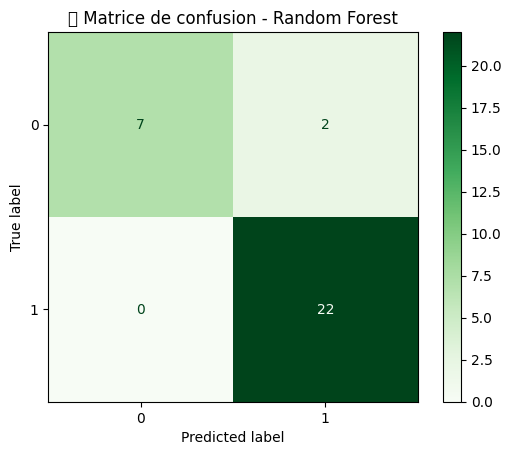

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matrice de confusion pour le modèle Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap='Greens')
plt.title("📉 Matrice de confusion - Random Forest")
plt.show()


### <center> XGBoost  </center>

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report



In [15]:
# Création du modèle
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)



In [16]:
# Entraînement
xgb_model.fit(X_train, y_train)

# Prédiction
y_pred_xgb = xgb_model.predict(X_test)



In [17]:
# Évaluation
print("📊 Résultats du modèle XGBoost")
print(classification_report(y_test, y_pred_xgb))

📊 Résultats du modèle XGBoost
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.95      0.98        22

    accuracy                           0.97        31
   macro avg       0.95      0.98      0.96        31
weighted avg       0.97      0.97      0.97        31



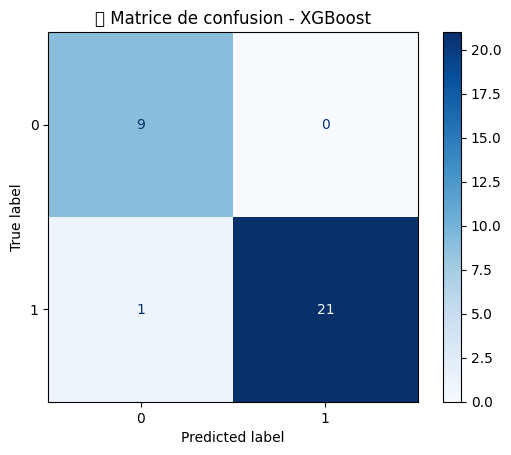

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("📉 Matrice de confusion - XGBoost")
plt.show()


### Hyperparameters

In [19]:
# Définir le modèle de base
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}




In [20]:
# Recherche des meilleurs paramètres
grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    cv=3, scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

In [21]:
# Meilleur modèle
best_xgb = grid_search.best_estimator_
print("🎯 Meilleurs paramètres XGBoost : ", grid_search.best_params_)



🎯 Meilleurs paramètres XGBoost :  {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


In [22]:
from sklearn.metrics import classification_report
y_pred_best = best_xgb.predict(X_test)
print("📈 Rapport de classification après tuning :")
print(classification_report(y_test, y_pred_best))


📈 Rapport de classification après tuning :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        22

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



### Importance des variables

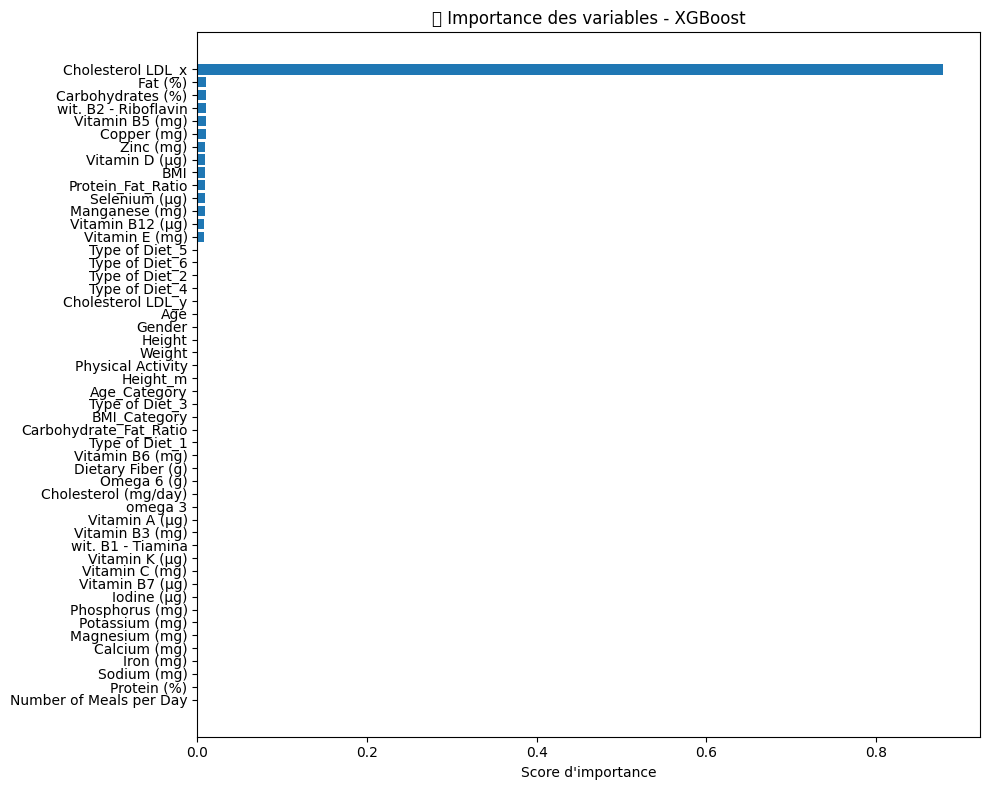

In [23]:
importances = best_xgb.feature_importances_
features = X_train.columns

# Tri des variables par importance
sorted_idx = importances.argsort()
plt.figure(figsize=(10, 8))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("🔍 Importance des variables - XGBoost")
plt.xlabel("Score d'importance")
plt.tight_layout()
plt.show()


In [24]:
import pickle

# Sauvegarder le meilleur modèle dans un fichier
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

print("✅ Modèle sauvegardé dans 'best_xgb_model.pkl'")


✅ Modèle sauvegardé dans 'best_xgb_model.pkl'


In [25]:
# Charger le modèle XGBoost sauvegardé
path=r"C:\Users\PC\Desktop\ESISA\4 eme - Semestre 2\Data Mining\Projet santé 2\Projet santé 2\implementation\notebook\best_xgb_model.pkl"
with open(path, 'rb') as f:
    best_xgb = pickle.load(f)


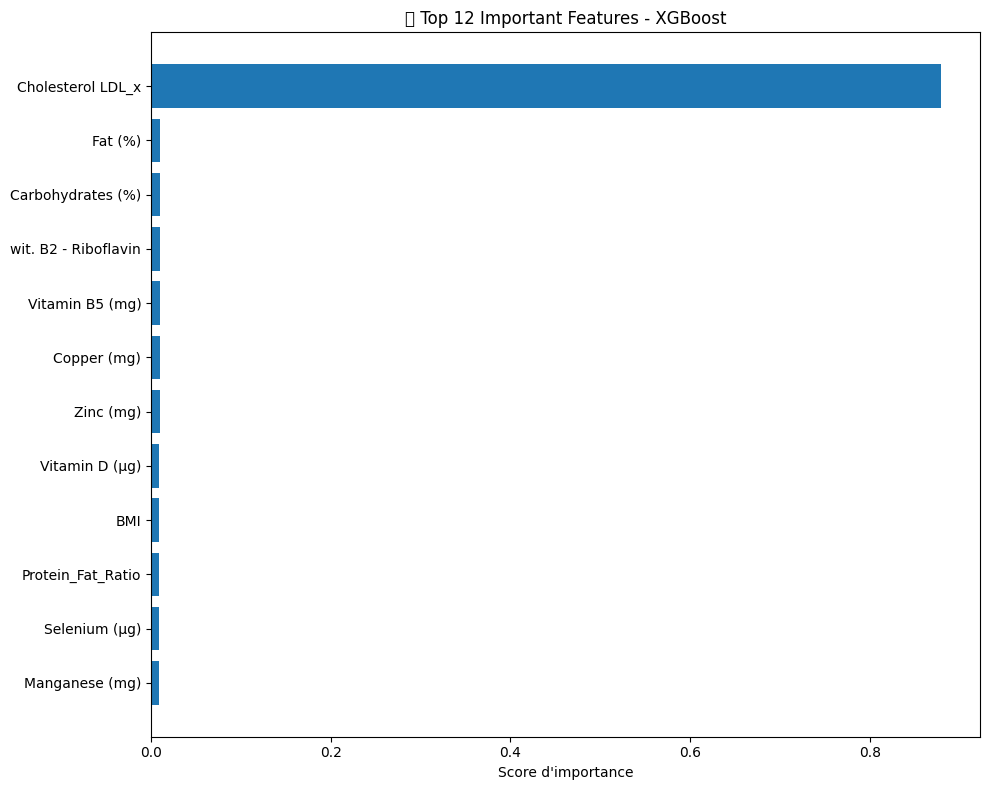

In [26]:
importances = best_xgb.feature_importances_
features = X_train.columns

# Combine features and importances into a DataFrame for easier manipulation
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 12 features
top_12_features = feature_importance_df.head(12)

# Plot only the top 12 features
plt.figure(figsize=(10, 8))
plt.barh(top_12_features['Feature'][::-1], top_12_features['Importance'][::-1])  # [::-1] to reverse for proper ordering
plt.title("🔍 Top 12 Important Features - XGBoost")
plt.xlabel("Score d'importance")
plt.tight_layout()
plt.show()

In [27]:
print(top_12_features)

                 Feature  Importance
0      Cholesterol LDL_x    0.878863
3                Fat (%)    0.010235
4      Carbohydrates (%)    0.010137
21  wit. B2 - Riboflavin    0.009882
23       Vitamin B5 (mg)    0.009766
14           Copper (mg)    0.009728
11             Zinc (mg)    0.009561
18        Vitamin D (µg)    0.009492
39                   BMI    0.009237
42     Protein_Fat_Ratio    0.009124
13         Selenium (µg)    0.008925
15        Manganese (mg)    0.008700


## TOP 12 

Fitting 3 folds for each of 108 candidates, totalling 324 fits
🎯 Meilleurs paramètres XGBoost :  {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
📈 Rapport de classification après tuning :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        22

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



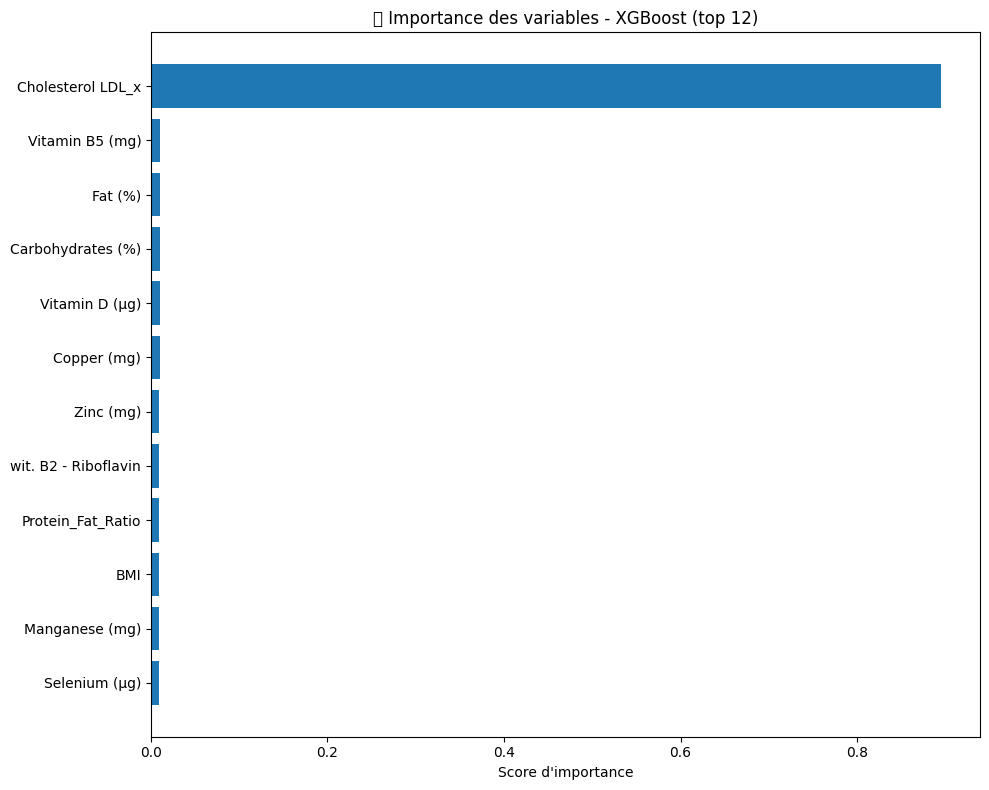

✅ Nouveau modèle sauvegardé dans 'best_xgb_model_top12.pkl'


In [30]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Liste des 12 meilleures variables
top_features = [
    "Cholesterol LDL_x",
    "Fat (%)",
    "Carbohydrates (%)",
    "wit. B2 - Riboflavin",
    "Vitamin B5 (mg)",
    "Copper (mg)",
    "Zinc (mg)",
    "Vitamin D (µg)",
    "BMI",
    "Protein_Fat_Ratio",
    "Selenium (µg)",
    "Manganese (mg)"
]

# Sélection uniquement des top features
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

#  Définir le modèle de base
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

#  Grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

#  Recherche des meilleurs paramètres
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_reduced, y_train)

#  Meilleur modèle entraîné
best_xgb = grid_search.best_estimator_
print(" Meilleurs paramètres XGBoost : ", grid_search.best_params_)

# Évaluation
y_pred_best = best_xgb.predict(X_test_reduced)
print(" Rapport de classification après tuning :")
print(classification_report(y_test, y_pred_best))

#  Importance des variables (top 12)
importances = best_xgb.feature_importances_
features = X_train_reduced.columns

#  Affichage des importances
sorted_idx = importances.argsort()
plt.figure(figsize=(10, 8))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title(" Importance des variables - XGBoost (top 12)")
plt.xlabel("Score d'importance")
plt.tight_layout()
plt.show()

#  Sauvegarde du modèle
with open("best_xgb_model_top12.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

print(" Nouveau modèle sauvegardé dans 'best_xgb_model_top12.pkl'")


In [32]:
import pandas as pd
import pickle

# 💾 Charger le modèle entraîné
with open("best_xgb_model_top12.pkl", "rb") as f:
    best_xgb = pickle.load(f)

# 🔢 Exemple de donnée test (valeurs fictives — remplace-les par les tiennes)
donnee_test = pd.DataFrame([{
    "Cholesterol LDL_x": 2.3,
    "Fat (%)": 30,
    "Carbohydrates (%)": 50,
    "wit. B2 - Riboflavin": 1.2,
    "Vitamin B5 (mg)": 4.5,
    "Copper (mg)": 0.9,
    "Zinc (mg)": 10.2,
    "Vitamin D (µg)": 5.3,
    "BMI": 24.8,
    "Protein_Fat_Ratio": 0.9,
    "Selenium (µg)": 60.0,
    "Manganese (mg)": 2.1
}])

# 🧠 Prédiction
prediction = best_xgb.predict(donnee_test)[0]

# ✅ Interprétation
if prediction == 0:
    print("✅ Prédiction : Faible risque")
else:
    print("🚨 Prédiction : Haut risque")


✅ Prédiction : Faible risque


In [34]:
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 📂 Charger le modèle sauvegardé
with open("best_xgb_model_top12.pkl", "rb") as f:
    best_xgb = pickle.load(f)

# 📋 Liste des 12 variables utilisées
top_features = [
    "Cholesterol LDL_x",
    "Fat (%)",
    "Carbohydrates (%)",
    "wit. B2 - Riboflavin",
    "Vitamin B5 (mg)",
    "Copper (mg)",
    "Zinc (mg)",
    "Vitamin D (µg)",
    "BMI",
    "Protein_Fat_Ratio",
    "Selenium (µg)",
    "Manganese (mg)"
]

X_test_reduced = X_test[top_features]
y_test_reduced = y_test

y_pred = best_xgb.predict(X_test_reduced)

print("🔍 Comparaison entre vraies classes et prédictions :\n")
for i in range(len(y_test_reduced)):
    vrai = y_test_reduced.iloc[i]
    predit = y_pred[i]
    resultat = "✔️ Correct" if vrai == predit else "❌ Incorrect"
    interpretation = "Faible" if predit == 0 else "Haut Risque"
    print(f"Exemple {i+1:02d} | Vrai: {vrai} | Prédit: {predit} ({interpretation}) → {resultat}")


🔍 Comparaison entre vraies classes et prédictions :

Exemple 01 | Vrai: 0 | Prédit: 0 (Faible) → ✔️ Correct
Exemple 02 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 03 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 04 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 05 | Vrai: 0 | Prédit: 0 (Faible) → ✔️ Correct
Exemple 06 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 07 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 08 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 09 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 10 | Vrai: 0 | Prédit: 0 (Faible) → ✔️ Correct
Exemple 11 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 12 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 13 | Vrai: 0 | Prédit: 0 (Faible) → ✔️ Correct
Exemple 14 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 15 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple 16 | Vrai: 1 | Prédit: 1 (Haut Risque) → ✔️ Correct
Exemple